# Training and Inference Module

We modularized commonly used codes for training and inference in the `module` (or `mod` for short) package. This package provides intermediate-level and high-level interface for executing predefined networks. 


## Basic Usage

### Preliminary

In this tutorial, we will use a simple multilayer perception for 10 classes and a synthetic dataset. 

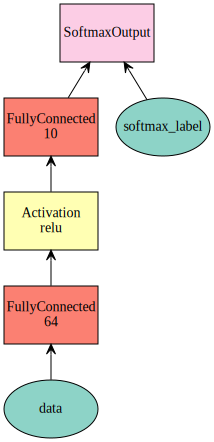

In [1]:
import mxnet as mx
from data_iter import SyntheticData

# mlp
net = mx.sym.Variable('data')
net = mx.sym.FullyConnected(net, name='fc1', num_hidden=64)
net = mx.sym.Activation(net, name='relu1', act_type="relu")
net = mx.sym.FullyConnected(net, name='fc2', num_hidden=10)
net = mx.sym.SoftmaxOutput(net, name='softmax')
# synthetic 10 classes dataset with 128 dimension 
data = SyntheticData(10, 128)
mx.viz.plot_network(net)

### Create Module

The most widely used module class is `Module`, which wraps a `Symbol` and one or more `Executor`s.

We construct a module by specify

- symbol : the network Symbol
- context : the device (or a list of devices) for execution
- data_names : the list of data variable names 
- label_names : the list of label variable names

One can refer to [data.ipynb](./data.ipynb) for more explanations about the last two arguments. Here we have only one data named `data`, and one label, with the name `softmax_label`, which is automatically named for us following the name `softmax` we specified for the `SoftmaxOutput` operator.

In [2]:
mod = mx.mod.Module(symbol=net, 
                    context=mx.cpu(),
                    data_names=['data'], 
                    label_names=['softmax_label'])

### Train, Predict, and Evaluate

Modules provide high-level APIs for training, predicting and evaluating. To fit a module, simply call the `fit` function with some `DataIters`. 

In [3]:
# @@@ AUTOTEST_OUTPUT_IGNORED_CELL
import logging
logging.basicConfig(level=logging.INFO)

batch_size=32
mod.fit(data.get_iter(batch_size), 
        eval_data=data.get_iter(batch_size),
        optimizer='sgd',
        optimizer_params={'learning_rate':0.1},
        eval_metric='acc',
        num_epoch=5)

INFO:root:Epoch[0] Train-accuracy=0.081250
INFO:root:Epoch[0] Time cost=0.103
INFO:root:Epoch[0] Validation-accuracy=0.228125
INFO:root:Epoch[1] Train-accuracy=0.178125
INFO:root:Epoch[1] Time cost=0.070
INFO:root:Epoch[1] Validation-accuracy=0.181250
INFO:root:Epoch[2] Train-accuracy=0.150000
INFO:root:Epoch[2] Time cost=0.061
INFO:root:Epoch[2] Validation-accuracy=0.112500
INFO:root:Epoch[3] Train-accuracy=0.196875
INFO:root:Epoch[3] Time cost=0.073
INFO:root:Epoch[3] Validation-accuracy=0.187500
INFO:root:Epoch[4] Train-accuracy=0.250000
INFO:root:Epoch[4] Time cost=0.076
INFO:root:Epoch[4] Validation-accuracy=0.078125


To predict with a module, simply call `predict()` with a `DataIter`. It will collect and return all the prediction results.

In [4]:
y = mod.predict(data.get_iter(batch_size))
'shape of predict: %s' % (y.shape,)

'shape of predict: (320L, 10L)'

Another convenient API for prediction in the case where the prediction results might be too large to fit in the memory is `iter_predict`:

In [5]:
# @@@ AUTOTEST_OUTPUT_IGNORED_CELL
for preds, i_batch, batch in mod.iter_predict(data.get_iter(batch_size)):
    pred_label = preds[0].asnumpy().argmax(axis=1)
    label = batch.label[0].asnumpy().astype('int32')
    print('batch %d, accuracy %f' % (i_batch, float(sum(pred_label==label))/len(label)))

batch 0, accuracy 0.062500
batch 1, accuracy 0.156250
batch 2, accuracy 0.187500
batch 3, accuracy 0.000000
batch 4, accuracy 0.062500
batch 5, accuracy 0.000000
batch 6, accuracy 0.062500
batch 7, accuracy 0.093750
batch 8, accuracy 0.062500
batch 9, accuracy 0.062500


If we do not need the prediction outputs, but just need to evaluate on a test set, we can call the `score()` function with a `DataIter` and a `EvalMetric`:

In [6]:
# @@@ AUTOTEST_OUTPUT_IGNORED_CELL
mod.score(data.get_iter(batch_size), ['mse', 'acc'])

[('mse', 27.438781929016113), ('accuracy', 0.115625)]

### Save and Load

We can save the module parameters in each training epoch by using a checkpoint callback.

In [7]:
# @@@ AUTOTEST_OUTPUT_IGNORED_CELL
# construct a callback function to save checkpoints
model_prefix = 'mx_mlp'
checkpoint = mx.callback.do_checkpoint(model_prefix)

mod = mx.mod.Module(symbol=net)
mod.fit(data.get_iter(batch_size), num_epoch=5, epoch_end_callback=checkpoint)

INFO:root:Epoch[0] Train-accuracy=0.140625
INFO:root:Epoch[0] Time cost=0.062
INFO:root:Saved checkpoint to "mx_mlp-0001.params"
INFO:root:Epoch[1] Train-accuracy=0.106250
INFO:root:Epoch[1] Time cost=0.075
INFO:root:Saved checkpoint to "mx_mlp-0002.params"
INFO:root:Epoch[2] Train-accuracy=0.146875
INFO:root:Epoch[2] Time cost=0.084
INFO:root:Saved checkpoint to "mx_mlp-0003.params"
INFO:root:Epoch[3] Train-accuracy=0.140625
INFO:root:Epoch[3] Time cost=0.077
INFO:root:Saved checkpoint to "mx_mlp-0004.params"
INFO:root:Epoch[4] Train-accuracy=0.190625
INFO:root:Epoch[4] Time cost=0.073
INFO:root:Saved checkpoint to "mx_mlp-0005.params"


To load the saved module parameters, call the `load_checkpoint` function. It load the Symbol and the associated parameters. We can then set the loaded parameters into the module. 

In [8]:
sym, arg_params, aux_params = mx.model.load_checkpoint(model_prefix, 3)
print(sym.tojson() == net.tojson())

# assign the loaded parameters to the module
mod.set_params(arg_params, aux_params)

True


Or if we just want to resume training from a saved checkpoint, instead of calling `set_params()`, we can directly call `fit()`, passing the loaded parameters, so that `fit()` knows to start from those parameters instead of initializing from random. We also set the `begin_epoch` so that so that `fit()` knows we are resuming from a previous saved epoch.
 

In [9]:
# @@@ AUTOTEST_OUTPUT_IGNORED_CELL
mod = mx.mod.Module(symbol=sym)
mod.fit(data.get_iter(batch_size),
        num_epoch=5,
        arg_params=arg_params, 
        aux_params=aux_params,
        begin_epoch=3)

INFO:root:Epoch[3] Train-accuracy=0.115625
INFO:root:Epoch[3] Time cost=0.064
INFO:root:Epoch[4] Train-accuracy=0.115625
INFO:root:Epoch[4] Time cost=0.058


## Module as a computation "machine"

We already seen how to module for basic training and inference. Now we are going to show a more flexiable usage of module.

A module represents a computation component. The design purpose of a module is that it abstract a computation “machine”, that accpets `Symbol` programs and data, and then we can run forward, backward, update parameters, etc. 

We aim to make the APIs easy and flexible to use, especially in the case when we need to use imperative API to work with multiple modules (e.g. stochastic depth network).

A module has several states:
- **Initial state**. Memory is not allocated yet, not ready for computation yet.
- **Binded**. Shapes for inputs, outputs, and parameters are all known, memory allocated, ready for computation.
- **Parameter initialized**. For modules with parameters, doing computation before initializing the parameters might result in undefined outputs.
- **Optimizer installed**. An optimizer can be installed to a module. After this, the parameters of the module can be updated according to the optimizer after gradients are computed (forward-backward).

The following codes implement a simplified `fit()`. Here we used other components including initializer, optimizer, and metric, which are explained in other notebooks.

In [10]:
# @@@ AUTOTEST_OUTPUT_IGNORED_CELL
# initial state
mod = mx.mod.Module(symbol=net)

# bind, tell the module the data and label shapes, so
# that memory could be allocated on the devices for computation
train_iter = data.get_iter(batch_size)
mod.bind(data_shapes=train_iter.provide_data, label_shapes=train_iter.provide_label)

# init parameters
mod.init_params(initializer=mx.init.Xavier(magnitude=2.))

# init optimizer
mod.init_optimizer(optimizer='sgd', optimizer_params=(('learning_rate', 0.1), ))

# use accuracy as the metric
metric = mx.metric.create('acc')

# train one epoch, i.e. going over the data iter one pass
for batch in train_iter:
    mod.forward(batch, is_train=True)       # compute predictions
    mod.update_metric(metric, batch.label)  # accumulate prediction accuracy
    mod.backward()                          # compute gradients
    mod.update()                            # update parameters using SGD
    
# training accuracy
print(metric.get())

('accuracy', 0.59375)


Beside the operations, a module provides a lot of useful information.

basic names:
- **data_names**: list of string indicating the names of the required data.
- **output_names**: list of string indicating the names of the outputs.

state information
- **binded**: bool, indicating whether the memory buffers needed for computation has been allocated.
- **for_training**: whether the module is binded for training (if binded).
- **params_initialized**: bool, indicating whether the parameters of this modules has been initialized.
- **optimizer_initialized**: bool, indicating whether an optimizer is defined and initialized.
- **inputs_need_grad**: bool, indicating whether gradients with respect to the input data is needed. Might be useful when implementing composition of modules.

input/output information
- **data_shapes**: a list of (name, shape). In theory, since the memory is allocated, we could directly provide the data arrays. But in the case of data parallelization, the data arrays might not be of the same shape as viewed from the external world.
- **label_shapes**: a list of (name, shape). This might be [] if the module does not need labels (e.g. it does not contains a loss function at the top), or a module is not binded for training.
- **output_shapes**: a list of (name, shape) for outputs of the module.

parameters (for modules with parameters)
- **get_params()**: return a tuple (arg_params, aux_params). Each of those is a dictionary of name to NDArray mapping. Those NDArray always lives on CPU. The actual parameters used for computing might live on other devices (GPUs), this function will retrieve (a copy of) the latest parameters.
- **get_outputs()**: get outputs of the previous forward operation.
- **get_input_grads()**: get the gradients with respect to the inputs computed in the previous backward operation.


In [11]:
print((mod.data_shapes, mod.label_shapes, mod.output_shapes))
print(mod.get_params())

([DataDesc[data,(32, 128),<type 'numpy.float32'>,NCHW]], [DataDesc[softmax_label,(32,),<type 'numpy.float32'>,NCHW]], [('softmax_output', (32, 10L))])
({'fc2_bias': <NDArray 10 @cpu(0)>, 'fc2_weight': <NDArray 10x64 @cpu(0)>, 'fc1_bias': <NDArray 64 @cpu(0)>, 'fc1_weight': <NDArray 64x128 @cpu(0)>}, {})


## More on Modules

Module simplifies the implementation of new modules. For example

- [`SequentialModule`](https://github.com/dmlc/mxnet/blob/master/python/mxnet/module/sequential_module.py) can chain multiple modules together
- [`BucketingModule`](https://github.com/dmlc/mxnet/blob/master/python/mxnet/module/bucketing_module.py) is able to handle bucketing, which is useful for various length inputs and outputs
- [`PythonModule`](https://github.com/dmlc/mxnet/blob/master/python/mxnet/module/python_module.py) implements many APIs as empty function to ease users to implement customized modules. 

See also [example/module](https://github.com/dmlc/mxnet/tree/master/example/module) for a list of code examples using the module API.

## Implementation

The `module` is implemented in python, located at [python/mxnet/module](https://github.com/dmlc/mxnet/tree/master/python/mxnet/module) 

## Futher Readings

- [module API doc](http://mxnet.io/packages/python/module.html#module-interface-api)